In [1]:
from ngsolve import *
# import netgen.gui
from netgen.geom2d import unit_square
import numpy as np
import netgen.geom2d

In [2]:
## unchangeable Globals
import scipy.sparse as sparse

# mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))
geo = netgen.geom2d.SplineGeometry()
p1 = geo.AppendPoint (0,0)
p2 = geo.AppendPoint (np.pi,0)
p3 = geo.AppendPoint (np.pi, np.pi)
p4 = geo.AppendPoint (0,np.pi)

geo.Append (["line", p1, p2], bc = "b")
geo.Append (["line", p2, p3], bc = "r")
geo.Append (["line", p3, p4], bc = "t")
geo.Append (["line", p4, p1], bc = "l")

mesh = Mesh(geo.GenerateMesh(maxh=0.1))

## Todo: don't compare coefficients of bondary functions if dirichlet
fes = H1(mesh, order=5)#dirichlet='top|bottom|left|right')
u,v =fes.TnT()


x_0 = 0.3
y_0 = 0.6
factor = 25

func = exp(-factor*((x-x_0)**2 + (y-y_0)**2))

f = LinearForm(fes)
f += func * v * dx
f.Assemble()

omega = Parameter(0)
a = BilinearForm(fes)
a += (grad(u)*grad(v) - omega*omega *u*v) * dx
a.Assemble()

gfu = GridFunction(fes)

k_blf = BilinearForm(fes)
k_blf += grad(u)*grad(v)*dx
k_blf.Assemble()
rows,cols,vals = k_blf.mat.COO()
K_orig = sparse.csr_matrix((vals,(rows,cols)))

m_blf = BilinearForm(fes)
m_blf += u*v * dx
m_blf.Assemble()
rows,cols,vals = m_blf.mat.COO()
M_orig = sparse.csr_matrix((vals,(rows,cols)))


In [3]:
def GramSchmidt (V, u):
    if V ==[]:
        z = u
    else:
        #computational expensive
        V_mat = np.array(V)
        z = u - np.transpose(V_mat).dot(V_mat).dot(u)
    z = z/np.linalg.norm(z)
    V += [z]
    return V

In [4]:
def computeRB(snapshots):
    global V, dim_orig, norm_of_solutions_orig, norm_of_solutions_red, sol
    global K_red, M_red, P_red, K_orig, M_orig, f, gfu, a
    
    dim_red = len(snapshots)
    V_tmp = np.zeros((dim_orig,dim_red))
    
    try: 
        existing_basis_len = V.shape[1]
        V_tmp[:,0:existing_basis_len] = V
        print("extending basis")
    except:
        existing_basis_len = 0
        

    for n in range(0+existing_basis_len, dim_red):
        _omega = snapshots[n]
        ## compute FEM solution for parameter _omega
        omega.Set(_omega)
        a.Assemble()
        gfu.vec.data = a.mat.Inverse(fes.FreeDofs(), inverse="sparsecholesky") * f.vec
        nof = Integrate(gfu*gfu, mesh)
        norm_of_solutions_orig += [nof]
        V_tmp[:,n] = np.array(gfu.vec.data) 
        sol += [gfu.vec]
        # GramSchmidt(V, np.array(gfu.vec.data))

        if visual:
            Redraw()
            input("norm of solution {}: {}".format(_omega, nof))
    q, r = np.linalg.qr(V_tmp)
    V = V_tmp.dot(np.linalg.inv(r))
            
    K_red = np.transpose(V).dot(K_orig.dot(V))
    M_red = np.transpose(V).dot(M_orig.dot(V))
    P_red = np.transpose(V).dot(f.vec.data)

In [5]:
def computeResidual(param):
    global norm_of_solutions_red, residual, K_orig, M_orig, f, K_red, M_red, P_red, V
    global stepsize, reduced_stepsize
    norm_of_solutions_red = [] 
    residual = []

    ured = GridFunction(fes)
    tmp = GridFunction(fes)
    visual = False

    if visual: Draw(ured)
    j = 0
    norm_diff = []
    for _omega in param:

        A = K_orig-_omega*_omega*M_orig

        ## TODO: solve lgs
        Ainv = np.linalg.inv(K_red-_omega*_omega*M_red)
        red_sol_vec = np.matmul(Ainv, P_red)

        ured.vec.FV().NumPy()[:] = V.dot(red_sol_vec)[:]
        nof = Integrate(ured*ured, mesh)
        norm_of_solutions_red += [nof]
        res = np.linalg.norm(A.dot(np.array(ured.vec.data))-f.vec.data)

        try:
            if len(sol)==len(param):
                # for i in range(dim_orig):
                # print("ured: {} , sol: {}".format(ured.vec.data[i], sol[j][i]))
                  tmp.vec.FV().NumPy()[:] = sol[j][:] - ured.vec.data[:]
                  nof_orig = Integrate(tmp*tmp, mesh)
        except:
            pass

    #     print(res)
        #res = np.linalg.norm(A.dot(np.array(ured.vec))-np.array(f.vec.data))
        ## just for testing
    #     res = np.linalg.norm((K_orig-_omega*_omega*M_orig).dot(np.array(V[:,j]))-f.vec.data)
        residual += [res]
        #print("norm of solution {}: {}".format(_omega, nof))
        j += 1
        if visual:
            Redraw()
            input("norm of solution {}: {}".format(_omega, nof))


In [6]:
## Global variables that can change
## TODO: dictionary and function that resets them
visual = False
V = None
K_red = None
M_red = None
P_red = None
sol = []
norm_of_solutions_red = [] 
norm_of_solutions_orig = [] # l2 norm 
residual = []
beginning = 1
end = 5
dim_orig= len(gfu.vec)# dim of original space
dim_red  = None


if visual: Draw(gfu)

In [7]:
stepsize = 0.25
## TODO: write Globals in dictionary and reset them here
first_snapshot = np.arange(beginning,end, stepsize).tolist()
computeRB(first_snapshot)
computeResidual(first_snapshot)

In [8]:
test_omegas = np.random.uniform(beginning, end, 200).tolist() + first_snapshot
computeResidual(test_omegas)
print(len(residual))

216


[]

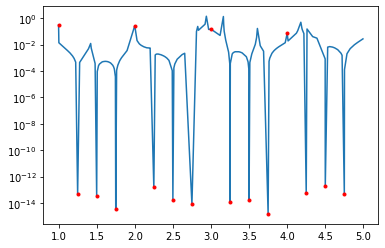

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# print(first_snapshot)
# print(residual[200:])

x = np.array(test_omegas)
y = np.array(residual)

zip_to_sort = list(zip(x, range(len(x))))
sorted_zip = sorted(zip_to_sort, key=lambda x: x[0], reverse=True)
indices = [tup[1] for tup in sorted_zip]

plt.plot(x[indices],y[indices], '-')

x = np.array(test_omegas[200:])
y = np.array(residual[200:])

zip_to_sort = list(zip(x, range(len(x))))
sorted_zip = sorted(zip_to_sort, key=lambda x: x[0], reverse=True)
indices = [tup[1] for tup in sorted_zip]

plt.plot(x[indices],y[indices], '.r')


plt.semilogy()

In [ ]:
zip_to_sort = list(zip(residual, range(0, len(residual))))
sorted_residuals = sorted(zip_to_sort, key=lambda x: x[0], reverse=True)[0:10]
indices = [tup[1] for tup in sorted_residuals]
second_snapshot = first_snapshot + np.array(test_omegas)[indices].tolist()
# print(second_snapshot)
computeRB(second_snapshot)

In [ ]:
computeResidual(second_snapshot)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
snapshot = list(second_snapshot)
print(len(snapshot))


eigenvalues = []
for j in range(beginning, 2*end+1):
    for i in range(beginning, 2*end+1):
        tmp = (i*i+j*j)**(1/2)*1/2
        if tmp <= end: eigenvalues += [tmp]
        
zip_to_sort = list(zip(snapshot, range(len(snapshot))))
sorted_zip = sorted(zip_to_sort, key=lambda x: x[0], reverse=True)
indices = [tup[1] for tup in sorted_zip]

ax.plot([snapshot[i] for i in indices], [norm_of_solutions_red[i] for i in indices], '-')
ax.plot(eigenvalues, np.ones(len(eigenvalues)), '.')
plt.yscale('log')